<div style="text-align: center; background-color:#440970; color: white; padding: 40px;">
    <h1 style="margin: 0; font-family: Arial, sans-serif; font-size: 3em;">
        Classification of Pediatric Chest X-ray Images: Normal vs. Pneumonia
    </h1>
</div>


#  Set Imports 

In [1]:
import warnings
warnings.filterwarnings('ignore')
import os
import matplotlib.pyplot as plt
import kagglehub
import torch
import numpy as np
from sklearn.metrics import classification_report,confusion_matrix
import seaborn as sns
import glob
from monai.data import decollate_batch, DataLoader,CacheDataset
from monai.metrics import ROCAUCMetric
from monai.networks.nets import VQVAE
from monai.transforms import(
     Activations,
     EnsureChannelFirstd,
     AsDiscrete, 
     Compose,
     LoadImaged,
     RandFlipd,
     RandRotate90d,
     Resized,
     ScaleIntensityRanged,
     RandFlipd,
     RandShiftIntensityd)
import torch.nn as nn
from monai.data import PILReader
from monai.utils import set_determinism
from pathlib import Path
from PIL import Image
from tqdm import tqdm
import torch.optim as optim
from collections import defaultdict
from monai.utils import set_determinism
import random

#  Download Dataset

In [2]:
path = kagglehub.dataset_download("andrewmvd/pediatric-pneumonia-chest-xray")
root_dir = Path(os.path.join(path, 'Pediatric Chest X-ray Pneumonia'))

In [3]:
set_determinism(seed=123)


# Dataset Preparation for Image Classification

In [4]:
train_dir = os.path.join(root_dir, 'train')
class_names = sorted([d for d in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, d))])
num_classes = len(class_names)
image_paths = [
    [os.path.join(train_dir, class_name, x) 
     for x in os.listdir(os.path.join(train_dir, class_name))]
    for class_name in class_names]
class_counts = [len(image_paths[i]) for i in range(num_classes)]


image_list = []
class_label_list = []
for i in range(num_classes):
    image_list.extend(image_paths[i])  
    class_label_list.extend([i] * class_counts[i])  

total_images = np.sum(class_counts)


class_counts = [len(image_paths[i]) for i in range(num_classes)]

class_frequencies = []
for count in class_counts:
    frequency = count / total_images  
    class_frequencies.append(frequency)


print(f"Class Frequencies (proportion of total images): {class_frequencies}")

Class Frequencies (proportion of total images): [0.25783639143730885, 0.7421636085626911]


In [5]:
data = [{"image": img_path, "label": label} for img_path, label in zip(image_list, class_label_list)]
class_to_items = defaultdict(list)

for item in data:
    class_to_items[item["label"]].append(item)

# Balance the dataset by undersampling to match the smaller class size
min_size = min(len(class_to_items[0]), len(class_to_items[1]))
balanced_class_0 = random.sample(class_to_items[0], min_size)
balanced_class_1 = random.sample(class_to_items[1], min_size)

random.shuffle(balanced_class_0)
random.shuffle(balanced_class_1)

# Define train and validation data
train_ratio = 0.8
train_len = int(train_ratio * min_size)

train_data = balanced_class_0[:train_len] + balanced_class_1[:train_len]
val_data = balanced_class_0[train_len:] + balanced_class_1[train_len:]

# Check balanced data
count_0 = len([item for item in train_data if item['label'] == 0])
count_1 = len([item for item in train_data if item['label'] == 1])
print(f"Number of healthy patients in train dataset: {count_0}")
print(f"Number of Pneumonia patients in train dataset: {count_1}")

Number of healthy patients in train dataset: 1079
Number of Pneumonia patients in train dataset: 1079


# Starting Pretext Task pre-training

#### Image Transformation Pipeline for Training and Validation for Pretext 

In [6]:
train_transforms = Compose([
    
    LoadImaged(keys=['image'],reader=PILReader(converter=lambda image: image.convert("L")), image_only=True), #convert image to gray scale
    EnsureChannelFirstd(keys=['image']),
    Resized(keys=['image'],spatial_size=(128,128),mode=['bilinear'],align_corners=True),    
    ScaleIntensityRanged(keys=["image"],a_min=0.0,a_max=250,b_min=0.0,b_max=1.0,clip=True),
    RandRotate90d(keys=['image'],prob=0.2,max_k=3),
    RandFlipd(keys=['image'],prob=0.2,spatial_axis= [0]),
    RandFlipd(keys=['image'],prob=0.2,spatial_axis=[1])])
val_transforms = Compose([
    LoadImaged(keys=['image'],reader=PILReader(converter=lambda image: image.convert("L")), image_only=True),
    EnsureChannelFirstd(keys=['image']),
    Resized(keys=['image'],spatial_size=(128,128),mode=['bilinear'],align_corners=True),    
    ScaleIntensityRanged(keys=["image"],a_min=0.0,a_max=250,b_min=0.0,b_max=1.0,clip=True)
    
])
 

In [7]:
train_dataset = CacheDataset(train_data,transform=train_transforms,num_workers=14)
train_loader = DataLoader(train_dataset,batch_size = 20,shuffle=True)
val_dataset = CacheDataset(val_data,transform=val_transforms,num_workers=14)
val_loader = DataLoader(val_dataset,batch_size=10,shuffle=True)

Loading dataset: 100%|███████████████████████████████████████████████████████████████| 540/540 [00:05<00:00, 97.58it/s]


## Visualizing Sample Images

Validation Batch:
Image shape: torch.Size([10, 1, 128, 128])


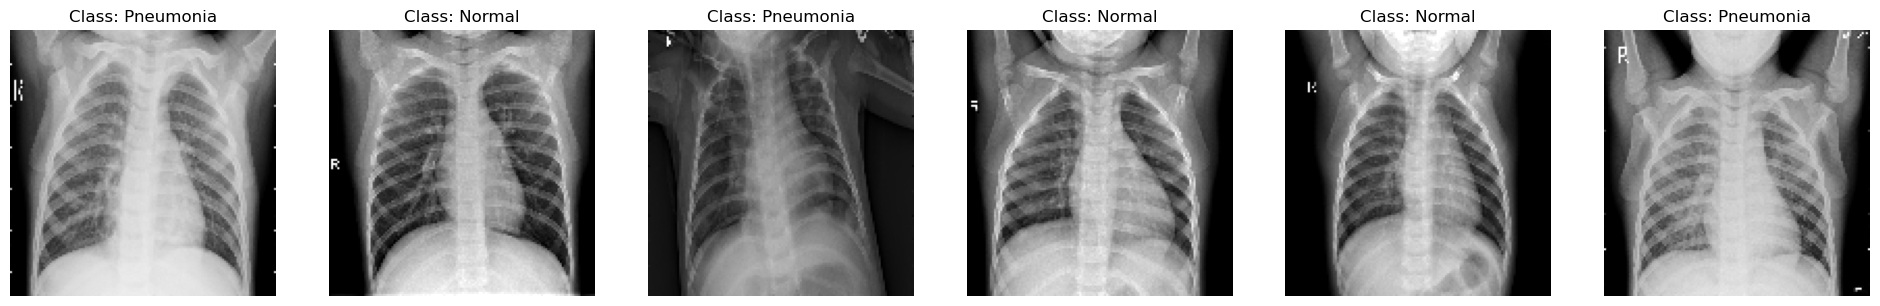

In [8]:

samples = next(iter(val_loader))
print("Validation Batch:")
print("Image shape:", samples["image"].shape)

plt.figure("image", (24, 6))
for i in range(6):
    plt.subplot(1, 6, i + 1)
   
    label = "Normal" if samples['label'][i] == 0 else "Pneumonia"
    plt.title(f"Class: {label}")
    plt.imshow(samples["image"][i, 0, :, :].T, cmap="gray")
    plt.axis("off")

plt.show()

## Pretext Task tranining of Vector Quantized Variational Autoencoder


In [9]:
device = torch.device("cuda:0")
#define modoel 
vq_model = VQVAE(
    spatial_dims=2,
in_channels=1,
    out_channels=1,
channels=(64,128,256),
num_res_layers=1,
num_res_channels=(64,128,256),
downsample_parameters=((2,3,2,2),(2,3,2,2),(2,3,2,2)),
upsample_parameters=((2,3,1,1,1),(2,3,1,1,1),(2,3,1,1,1)),
num_embeddings=256,
embedding_dim=128,
).to(device)

optimizer = optim.AdamW(vq_model.parameters(),lr=1e-4)
rec_loss = nn.L1Loss(reduction='mean')


In [10]:
max_epochs = 140
val_interval = 20
epoch_loss_list = []
val_loss_list = []
best_loss = float('inf')

for epoch in range(max_epochs):
    vq_model.train()
    epoch_loss = 0
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), leave=False)
    progress_bar.set_description(f"Epoch --> {epoch + 1}")
    
    for step, batch in progress_bar:
        images = batch['image'].to(device)
        optimizer.zero_grad(set_to_none=True)
        
        # Forward pass: compute reconstruction and quantization loss
        outputs, quantization_loss = vq_model(images)  
        recons_loss = rec_loss(outputs.float(), images.float())
        loss = recons_loss + quantization_loss  
        
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()  
        progress_bar.set_postfix({"loss": epoch_loss / (step + 1)})

    avg_epoch_loss = epoch_loss / (step + 1)
    epoch_loss_list.append(avg_epoch_loss)

    if (epoch + 1) % val_interval == 0:
        vq_model.eval()
        val_loss = 0.0
        with torch.no_grad():
            val_progress = tqdm(enumerate(val_loader), total=len(val_loader), leave=True)
            val_progress.set_description("Validation")
            for val_step, val_batch in val_progress:
                val_images = val_batch['image'].to(device)
                val_outputs, quantization_loss = vq_model(val_images)  
                recons_loss = rec_loss(val_outputs.float(), val_images.float())  
                loss = recons_loss + quantization_loss
                val_loss += loss.item()
                val_progress.set_postfix({"val_L1": val_loss / (val_step + 1)})
               
            avg_val_loss = val_loss / (val_step + 1)
            val_loss_list.append(avg_val_loss)

            if avg_val_loss < best_loss:
                best_loss = avg_val_loss
                torch.save(vq_model.state_dict(), os.path.join(root_dir, "best_vq_model.pth"))


Validation: 100%|███████████████████████████████████████████████████████| 54/54 [00:09<00:00,  5.54it/s, val_L1=0.0305]


## Plotting VQ-VAE Training and Validation Losses

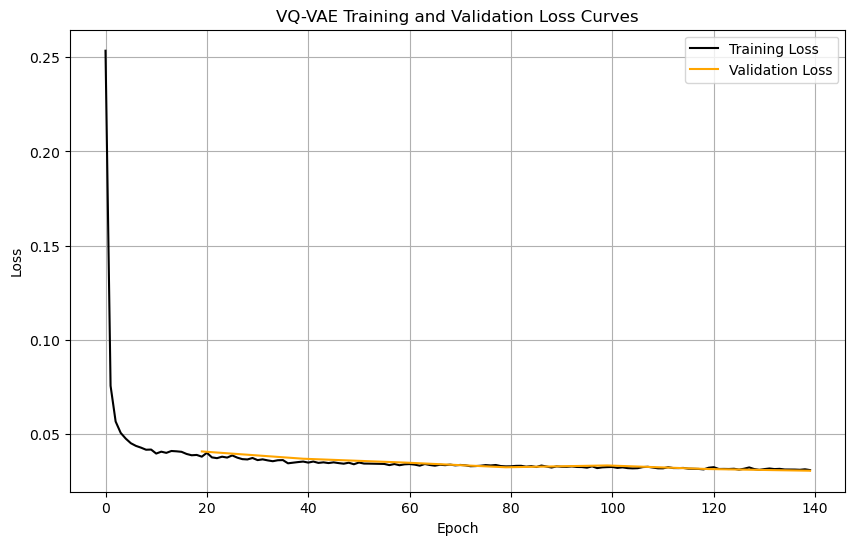

In [11]:
plt.figure(figsize=(10, 6))
plt.plot(epoch_loss_list, label="Training Loss", color="black")
plt.plot(range(val_interval - 1, max_epochs, val_interval), val_loss_list, label="Validation Loss", color="orange")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("VQ-VAE Training and Validation Loss Curves")
plt.legend()
plt.grid(True)
plt.show()

In [12]:
#Clear GPU memory cache
torch.cuda.empty_cache()

# Downstream Task
#### Define Classification Head

In [13]:
class VAEWithClassifier(nn.Module):
    def __init__(self,vqvae_model,num_classes,freeze_weights=True):       
        super().__init__()
        self.vqvae = vqvae_model
        if  freeze_weights:
            for param in self.vqvae.parameters():
                param.requires_grad =False
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.flatten = nn.Flatten()
        self.classifier = nn.Linear(128, num_classes)
        #intialize classification head with zero weights
        nn.init.zeros_(self.classifier.weight)
        nn.init.zeros_(self.classifier.bias)

    def forward(self, x):     
        z_q = self.vqvae.encode_stage_2_inputs(x) #use encoder part of vqvae model
        x = self.pool(z_q)
        x = self.flatten(x)
        x = self.classifier(x)
        return x


### loading pretrained Weights VQ-VAE Model

In [14]:
pretrained_path = os.path.join(root_dir, "best_vq_model.pth")
vq_model.load_state_dict(torch.load(os.path.join(root_dir, "best_vq_model.pth"), weights_only=True))
#vqvae model encoder with classification head 
model =VAEWithClassifier(vq_model,2,freeze_weights=False).to(device)

#### Fintune Image Transformation Pipeline for Training and Validation


In [15]:
#increase randomization prob for this task 
train_transforms = Compose([
    LoadImaged(keys=['image'],reader=PILReader(converter=lambda image: image.convert("L")), image_only=True),
    EnsureChannelFirstd(keys=['image']),
    Resized(keys=['image'],spatial_size=(128,128),mode=['bilinear'],align_corners=True),    
    ScaleIntensityRanged(keys=["image"],a_min=0.0,a_max=250,b_min=0.0,b_max=1.0,clip=True),
    RandRotate90d(keys=['image'],prob=0.5,max_k=3),
    RandFlipd(keys=['image'],prob=0.5,spatial_axis= [0]),
    RandFlipd(keys=['image'],prob=0.5,spatial_axis=[1]),
    RandShiftIntensityd(keys=['image'],offsets=0.05,prob=0.4)])
val_transforms = Compose([
    LoadImaged(keys=['image'],reader=PILReader(converter=lambda image: image.convert("L")), image_only=True),
    EnsureChannelFirstd(keys=['image']),
    Resized(keys=['image'],spatial_size=(128,128),mode=['bilinear'],align_corners=True),    
    ScaleIntensityRanged(keys=["image"],a_min=0.0,a_max=250,b_min=0.0,b_max=1.0,clip=True)
    
])
 

In [16]:
train_dataset = CacheDataset(train_data,transform=train_transforms,num_workers=14)
train_loader = DataLoader(train_dataset,batch_size =100,shuffle=True)
val_dataset = CacheDataset(val_data,transform=val_transforms,num_workers=14)
val_loader = DataLoader(val_dataset,batch_size=50,shuffle=True)

Loading dataset: 100%|██████████████████████████████████████████████████████████████| 540/540 [00:05<00:00, 102.80it/s]


### loss function and optimizer for training

In [17]:
# Convert logits to softmax probabilities
pred_trans = Compose(Activations(softmax=True))
# Convert label to onehot format
cls_trans = Compose([AsDiscrete(to_onehot=2)])
optimizer_c = torch.optim.AdamW(model.parameters(),lr=1e-5,weight_decay=1e-6)
cls_trans = Compose([AsDiscrete(to_onehot=2)])
loss_fn = nn.CrossEntropyLoss()
max_epochs = 150
val_interval = 10
auc_metric = ROCAUCMetric()

### Model Training

In [18]:
epoch_loss_ls = []
metric_values = []
acc_values = []
best_metric = -1
top_models = []
max_saved_models = 4

for epoch in range(max_epochs):
    model.train()
    epoch_loss = 0.0
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch + 1}", leave=False)
    for step, batch in progress_bar:
        images, labels = batch['image'].to(device), batch['label'].to(device)
        optimizer_c.zero_grad(set_to_none=True)
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer_c.step()
        epoch_loss += loss.item()
        progress_bar.set_postfix({"loss": epoch_loss / (step + 1)})

    avg_epoch_loss = epoch_loss / len(train_loader)
    epoch_loss_ls.append(avg_epoch_loss)

    if (epoch + 1) % val_interval == 0:
        model.eval()
        y_pred = torch.tensor([], dtype=torch.float32, device=device)
        y = torch.tensor([], dtype=torch.long, device=device)
        val_progress = tqdm(val_loader, total=len(val_loader), desc="Validation", leave=True)

        with torch.no_grad():
            for val_batch in val_progress:
                val_images = val_batch['image'].to(device)
                val_labels = val_batch['label'].to(device)
                preds = model(val_images)
                y_pred = torch.cat([y_pred, preds], dim=0)
                y = torch.cat([y, val_labels], dim=0)

        y_pred_act = [pred_trans(i) for i in decollate_batch(y_pred)]
        y_one_hot = [cls_trans(i) for i in decollate_batch(y, detach=False)]

        auc_metric(y_pred_act, y_one_hot)
        result = auc_metric.aggregate()
        auc_metric.reset()

        accuracy_value = torch.eq(y_pred.argmax(dim=1), y)
        acc_metric = accuracy_value.float().mean().item()
        metric_values.append(result)
        acc_values.append(acc_metric)
        print(f" AUC: {result:.4f}, Accuracy: {acc_metric:.4f}")

        model_path = os.path.join(root_dir, f"model_auc_{result:.4f}.pth")
        if len(top_models) < max_saved_models or result > min(top_models, key=lambda x: x[0])[0]:
            torch.save(model.state_dict(), model_path)
            print(f"Saved model with AUC: {result:.4f}")

            top_models.append((result, model_path))
            top_models = sorted(top_models, key=lambda x: x[0], reverse=True)[:max_saved_models]

   

Validation: 100%|██████████████████████████████████████████████████████████████████████| 11/11 [00:08<00:00,  1.25it/s]


 AUC: 0.9111, Accuracy: 0.8519
Saved model with AUC: 0.9111


Validation: 100%|██████████████████████████████████████████████████████████████████████| 11/11 [00:08<00:00,  1.26it/s]


 AUC: 0.9302, Accuracy: 0.8815
Saved model with AUC: 0.9302


Validation: 100%|██████████████████████████████████████████████████████████████████████| 11/11 [00:09<00:00,  1.20it/s]


 AUC: 0.9388, Accuracy: 0.8944
Saved model with AUC: 0.9388


Validation: 100%|██████████████████████████████████████████████████████████████████████| 11/11 [00:08<00:00,  1.29it/s]


 AUC: 0.9470, Accuracy: 0.8981
Saved model with AUC: 0.9470


Validation: 100%|██████████████████████████████████████████████████████████████████████| 11/11 [00:08<00:00,  1.24it/s]


 AUC: 0.9516, Accuracy: 0.8852
Saved model with AUC: 0.9516


Validation: 100%|██████████████████████████████████████████████████████████████████████| 11/11 [00:08<00:00,  1.28it/s]


 AUC: 0.9573, Accuracy: 0.9074
Saved model with AUC: 0.9573


Validation: 100%|██████████████████████████████████████████████████████████████████████| 11/11 [00:08<00:00,  1.23it/s]


 AUC: 0.9606, Accuracy: 0.9056
Saved model with AUC: 0.9606


Validation: 100%|██████████████████████████████████████████████████████████████████████| 11/11 [00:08<00:00,  1.28it/s]


 AUC: 0.9638, Accuracy: 0.9093
Saved model with AUC: 0.9638


Validation: 100%|██████████████████████████████████████████████████████████████████████| 11/11 [00:08<00:00,  1.34it/s]


 AUC: 0.9664, Accuracy: 0.9148
Saved model with AUC: 0.9664


Validation: 100%|██████████████████████████████████████████████████████████████████████| 11/11 [00:08<00:00,  1.31it/s]


 AUC: 0.9687, Accuracy: 0.9130
Saved model with AUC: 0.9687


Validation: 100%|██████████████████████████████████████████████████████████████████████| 11/11 [00:07<00:00,  1.39it/s]


 AUC: 0.9704, Accuracy: 0.9130
Saved model with AUC: 0.9704


Validation: 100%|██████████████████████████████████████████████████████████████████████| 11/11 [00:08<00:00,  1.37it/s]


 AUC: 0.9736, Accuracy: 0.9241
Saved model with AUC: 0.9736


Validation: 100%|██████████████████████████████████████████████████████████████████████| 11/11 [00:07<00:00,  1.41it/s]


 AUC: 0.9747, Accuracy: 0.9315
Saved model with AUC: 0.9747


Validation: 100%|██████████████████████████████████████████████████████████████████████| 11/11 [00:07<00:00,  1.38it/s]


 AUC: 0.9757, Accuracy: 0.9185
Saved model with AUC: 0.9757


Validation: 100%|██████████████████████████████████████████████████████████████████████| 11/11 [00:08<00:00,  1.37it/s]


 AUC: 0.9774, Accuracy: 0.9296
Saved model with AUC: 0.9774


### Plotting Model Training Loss and Metrics

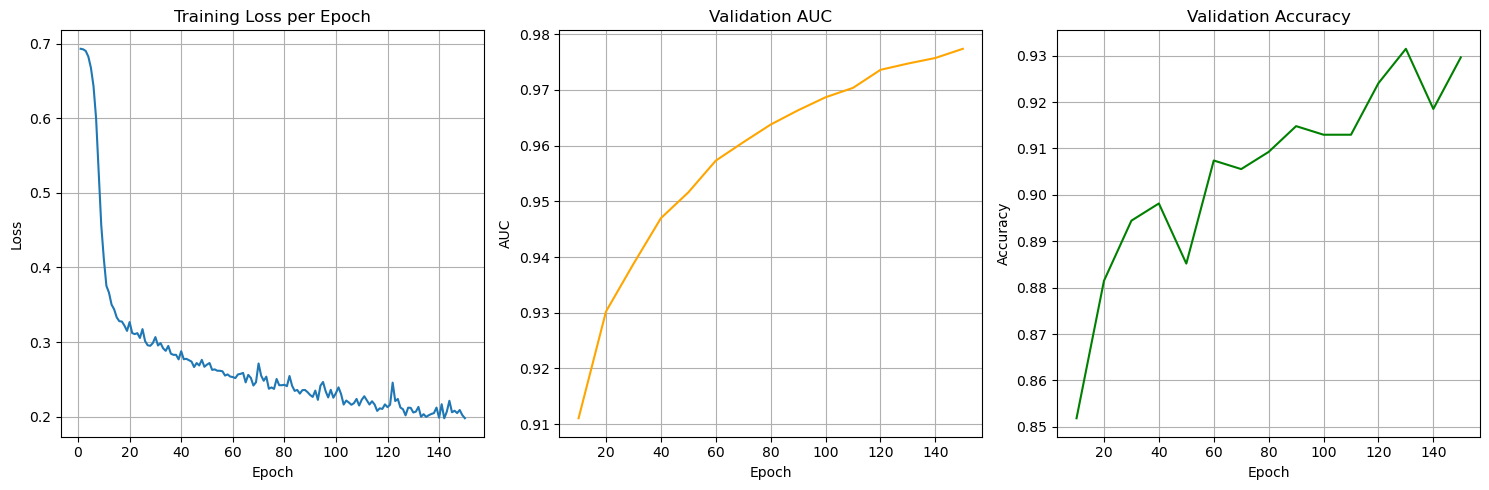

In [19]:
plt.figure(figsize=(15, 5))
# Epoch Loss plot
plt.subplot(1, 3, 1)
plt.plot(range(1, max_epochs + 1), epoch_loss_ls, label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss per Epoch")
plt.grid(True)

# AUC plot
val_epochs = list(range(val_interval, max_epochs + 1, val_interval))
plt.subplot(1, 3, 2)
plt.plot(val_epochs, metric_values, label="AUC", color='orange')
plt.xlabel("Epoch")
plt.ylabel("AUC")
plt.title("Validation AUC")
plt.grid(True)

# Accuracy plot
plt.subplot(1, 3, 3)

plt.plot(val_epochs, acc_values, label="Accuracy", color='green')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy")
plt.grid(True)

plt.tight_layout()
plt.show()


# Test The Model Performance on Test Data

In [20]:
for auc, path in top_models:
    print(f"AUC: {auc:.4f}, Path: {path}")

AUC: 0.9774, Path: C:\Users\Administrator\.cache\kagglehub\datasets\andrewmvd\pediatric-pneumonia-chest-xray\versions\1\Pediatric Chest X-ray Pneumonia\model_auc_0.9774.pth
AUC: 0.9757, Path: C:\Users\Administrator\.cache\kagglehub\datasets\andrewmvd\pediatric-pneumonia-chest-xray\versions\1\Pediatric Chest X-ray Pneumonia\model_auc_0.9757.pth
AUC: 0.9747, Path: C:\Users\Administrator\.cache\kagglehub\datasets\andrewmvd\pediatric-pneumonia-chest-xray\versions\1\Pediatric Chest X-ray Pneumonia\model_auc_0.9747.pth
AUC: 0.9736, Path: C:\Users\Administrator\.cache\kagglehub\datasets\andrewmvd\pediatric-pneumonia-chest-xray\versions\1\Pediatric Chest X-ray Pneumonia\model_auc_0.9736.pth


In [21]:
test_dir= os.path.join(root_dir,'test')
classes = os.listdir(test_dir)
class_to_idx = {cls: idx for idx, cls in enumerate(classes)}
test_data = [{"image": img_path, "label": class_to_idx[cls]} for cls in classes for img_path in glob.glob(os.path.join(test_dir, cls, '*.jpeg'))]
np.random.shuffle(test_data)
test_ds = CacheDataset(test_data,transform=val_transforms,num_workers=14)
test_loader= DataLoader(test_ds,batch_size=20)


Loading dataset: 100%|██████████████████████████████████████████████████████████████| 624/624 [00:05<00:00, 105.42it/s]


In [22]:
model.load_state_dict(torch.load(os.path.join(root_dir, "model_auc_0.9747.pth"), weights_only=True))
model.eval()
true_class = []
pred_class= []
with torch.no_grad():
    for test_data in test_loader:
        test_images, test_labels = test_data['image'].to(device),test_data['label'].to(device)
           
        pred = model(test_images).argmax(dim=1)
        for i in range(len(pred)):
            true_class.append(test_labels[i].item())
            pred_class.append(pred[i].item())

## Visualize Confusion Matrix

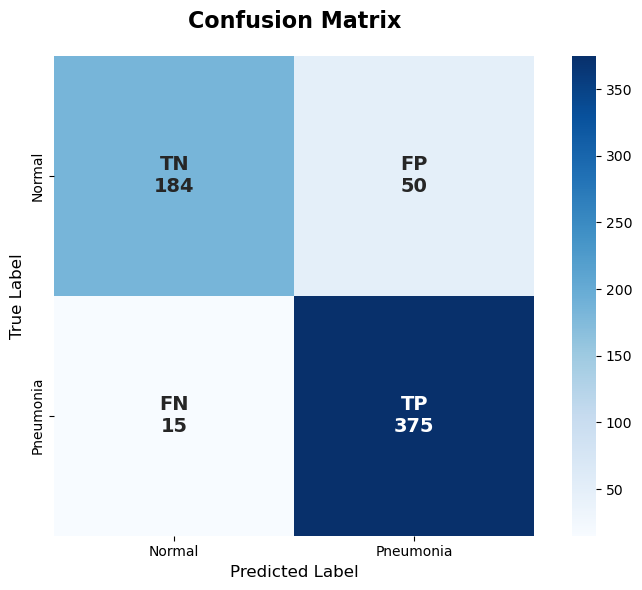

In [23]:
class_names = ['Normal', 'Pneumonia'] 
cm = confusion_matrix(true_class,pred_class)
TN, FP, FN, TP = cm.ravel()
annotations = np.array([
    [f'TN\n{TN}', f'FP\n{FP}'],
    [f'FN\n{FN}', f'TP\n{TP}']
])

plt.figure(figsize=(8, 6), dpi=100)
sns.heatmap(cm,annot=annotations,  fmt='',  cmap='Blues',  square=True,  cbar=True, xticklabels=class_names,yticklabels=class_names,annot_kws={'size': 14, 'weight': 'bold'})
plt.title('Confusion Matrix', fontsize=16, pad=20, weight='bold')
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

## Classification report 

In [24]:
print(classification_report(true_class,pred_class, target_names=classes, digits=4))

              precision    recall  f1-score   support

      NORMAL     0.9246    0.7863    0.8499       234
   PNEUMONIA     0.8824    0.9615    0.9202       390

    accuracy                         0.8958       624
   macro avg     0.9035    0.8739    0.8851       624
weighted avg     0.8982    0.8958    0.8939       624

